In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fredapi as fa

In [2]:
#pull data from FRED
fred = fa.Fred(api_key='b6bbb1bfe76d93bf0ca60a69b99d3474')
hyoas = fred.get_series('BAMLH0A0HYM2')
hyoas.name = 'HY_OAS'

data = pd.DataFrame(index=hyoas.index,data=hyoas.values,columns=['HY OAS']).dropna()
data

,HY OAS
1996-12-31,3.13
1997-01-02,3.06
1997-01-03,3.09
1997-01-06,3.10
1997-01-07,3.10
...,...
2022-08-23,4.68
2022-08-24,4.61
2022-08-25,4.60
2022-08-26,4.65


In [3]:
#ten year median
median_10y = data['HY OAS'].rolling('3650D').median()

#3 month rising or falling: 1 is rising
return_3m = (data['HY OAS'].pct_change()+1).rolling('91D').apply(np.prod)-1
return_3m = pd.DataFrame(index= return_3m.index, data= np.where(return_3m > 0, 1,0))

#add to data frame
data['10y Median'] = median_10y
data['3M Up/Down'] = return_3m

#data

In [4]:
#create cycle column
conditions = [
    (data['HY OAS']>data['10y Median']) & (data['3M Up/Down']==0),
    (data['HY OAS']<data['10y Median']) & (data['3M Up/Down']==0),
    (data['HY OAS']<data['10y Median']) & (data['3M Up/Down']==1)
]
choices = [1,2,3]

data['cycle'] = np.select(conditions, choices, default = 4)
data

,HY OAS,10y Median,3M Up/Down,cycle
1996-12-31,3.13,3.130,0,4
1997-01-02,3.06,3.095,0,2
1997-01-03,3.09,3.090,0,4
1997-01-06,3.10,3.095,0,1
1997-01-07,3.10,3.100,0,4
...,...,...,...,...
2022-08-23,4.68,4.190,0,1
2022-08-24,4.61,4.190,0,1
2022-08-25,4.60,4.190,1,4
2022-08-26,4.65,4.190,1,4


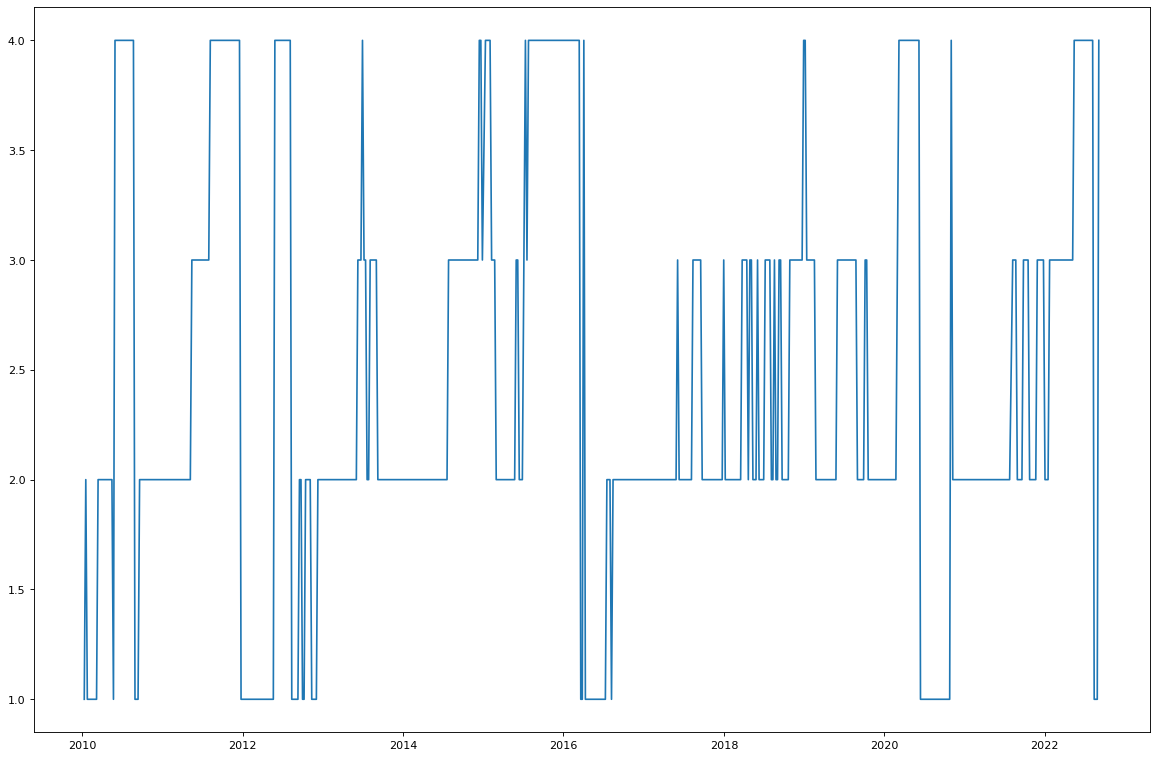

In [5]:
#plotting cycle over time
fig, ax = plt.subplots(1,1, figsize=(18,12), dpi= 80)

plt.plot(data.loc[data.index > '2010-01-01'].resample('W').median()['cycle'])
#ax.xaxis.label.set_rotation(90)

plt.show()

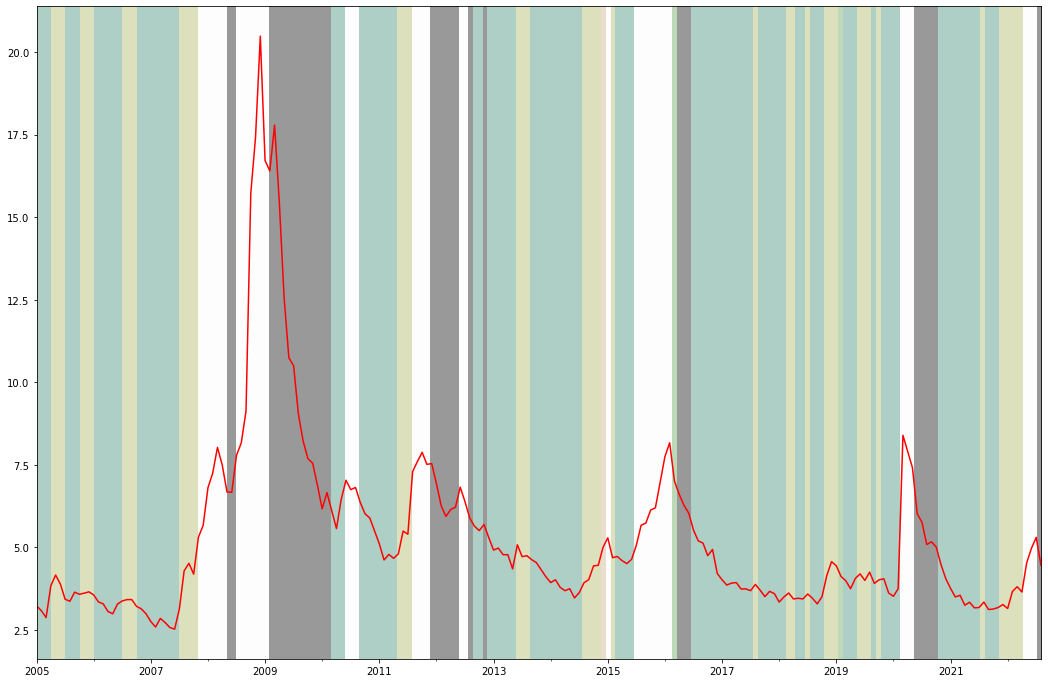

In [6]:
#plot cycle in background with HY OAS
data1 = data.loc[data.index>'2005-01-01'].resample('M').median()

ax = data1['HY OAS'].plot(figsize=(18,12),color='r')
ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),
              data1['cycle'].values[np.newaxis],
              cmap='gist_earth', alpha=0.4)
